# Import Libraries

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, models, transforms
from torch import nn, optim
import torch.nn.functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
import os
import copy

from torchvision.utils import make_grid
from torchsummary import summary
from sklearn import preprocessing

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cpu


#Datasets

##MNIST

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])
mnist_train = torchvision.datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# create batches
mnist_train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2642425.99it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 489726.04it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3880385.84it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8803386.68it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



##CIFAR10

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    ])

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train, batch_size=64, shuffle=True)
cifar10_test_dataloader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 41860545.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


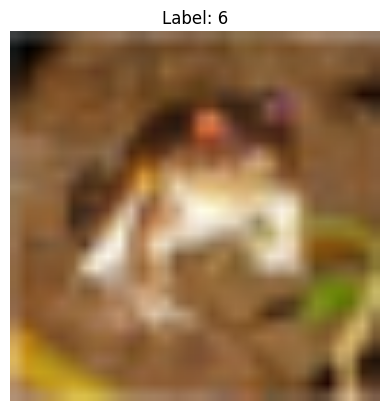

In [ ]:
# Get one image and label from the dataset
image, label = cifar10_train[0]

# Convert the tensor to a NumPy array for plotting
image = image.permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axes
plt.show()

##Flower102

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

flowers102_train = torchvision.datasets.Flowers102(
    root="./data",  # Directory where data will be downloaded
    split="train",  # You can choose "train", "val", or "test"
    download=True,  # Download dataset if not already present
    transform=transform  # Apply transformations to images
)

flowers102_test = torchvision.datasets.Flowers102(
    root="./data",
    split="test",
    download=True,
    transform=transform
)

flowers102_train_dataloader = DataLoader(flowers102_train, batch_size=64, shuffle=True)
flowers102_test_dataloader = DataLoader(flowers102_test, batch_size=64, shuffle=True)

100%|██████████| 344862509/344862509 [00:14<00:00, 23938228.63it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1400891.95it/s]


100%|██████████| 14989/14989 [00:00<00:00, 19640244.50it/s]


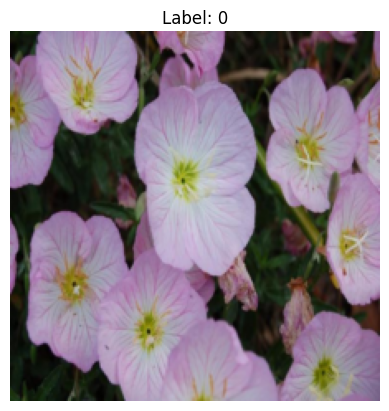

In [ ]:
# Get one image and label from the dataset
image, label = flowers102_train[0]

# Convert the tensor to a NumPy array for plotting
image = image.permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axes
plt.show()

# Generative Adversarial Network (GAN)

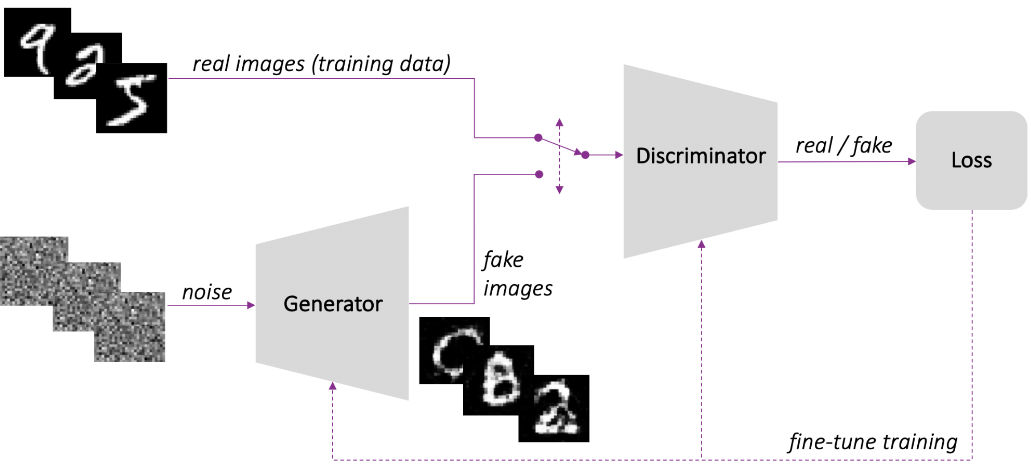

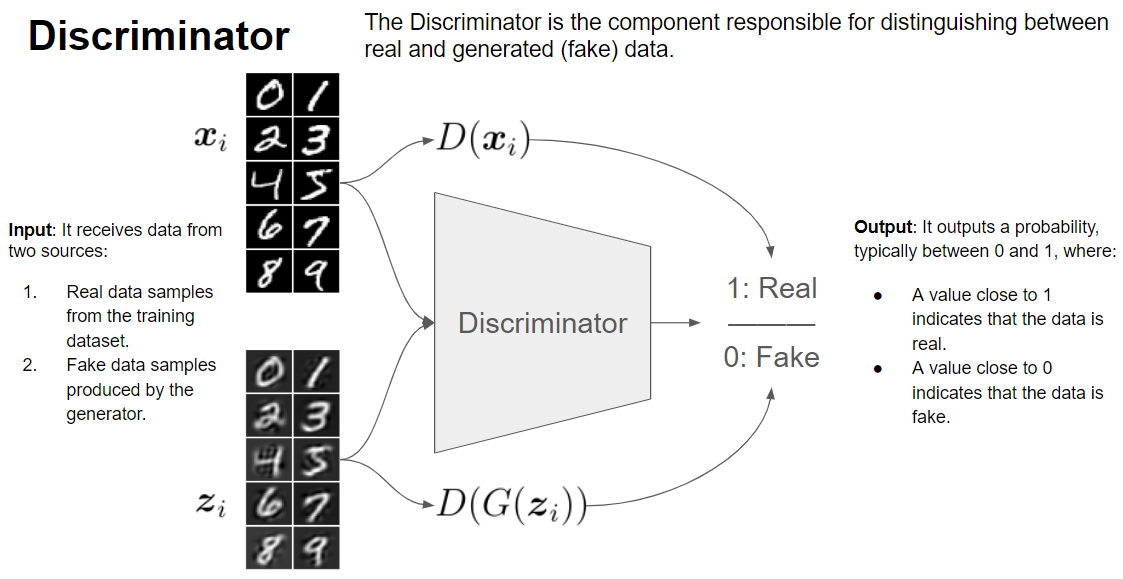

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,**kwargs):
        super(Discriminator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

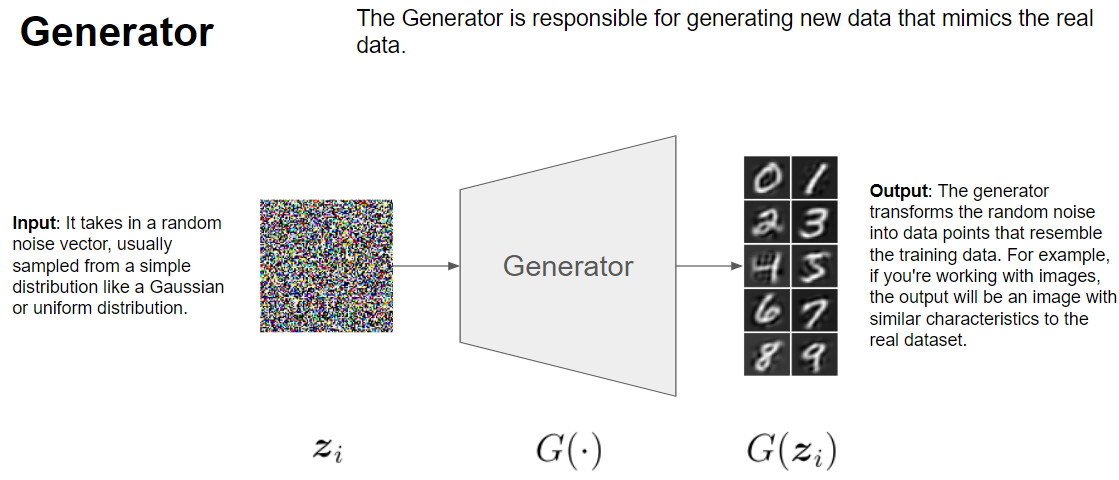

In [ ]:
class Generator(nn.Module):
    def __init__(self,**kwargs):
        super(Generator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh(),
        )
    def forward(self, batch_size):
        z = torch.randn(batch_size, 100).to(device)
        return self.net(z).view(-1, 28, 28)

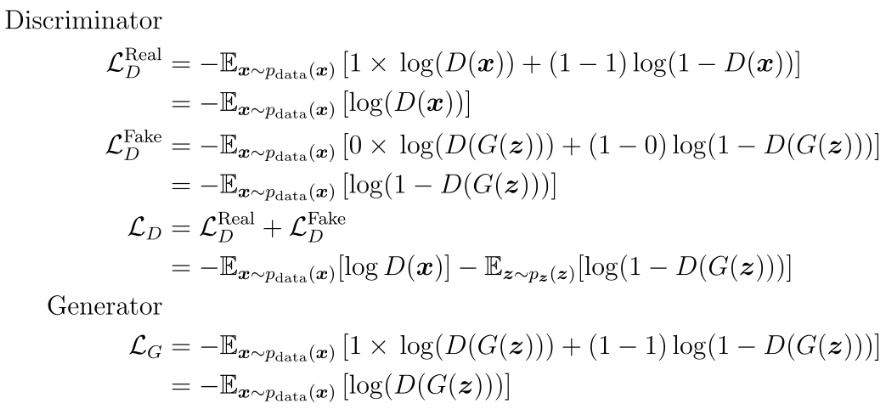

In [ ]:
def train_gan(
        dataloader,
        d_net,
        g_net,
        criterion = nn.BCELoss(),
        lr = 0.001,
        epochs = 20,
        optimizer = optim.Adam,
        ):
    d_optimizer = optimizer(d_net.parameters(), lr=lr)
    g_optimizer = optimizer(g_net.parameters(), lr=lr)

    for epoch in range(epochs):
        d_losses = []
        g_losses = []
        for images, labels in dataloader:
            batch_size = images.size(0)

            images = images.to(device)
            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)
            g_net.eval()
            with torch.no_grad():
                generated_images = g_net(batch_size)

            #===============================
            # Discriminator Network Training
            #===============================
            d_net.train()
            d_loss = criterion(d_net(images), real_label)
            d_loss += criterion(d_net(generated_images), fake_label)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            #===============================
            # Generator Network Training
            #===============================
            g_net.train()
            generated_images = g_net(batch_size)
            d_net.eval()
            g_loss = criterion(d_net(generated_images), real_label)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        print(f"epoch:{epoch}, discriminator's loss:{np.mean(d_losses)}, generator's loss:{np.mean(g_losses)}")

        if (epoch)%5==0:
            g_net.eval()
            with torch.no_grad():
                fake = g_net(100)

            images = fake.detach().to("cpu").view(-1, 1, 28, 28)
            images_grid = make_grid(images, nrow=10)
            plt.imshow(images_grid.permute(1, 2, 0).squeeze())
            plt.show()

epoch:0, discriminator's loss:0.8484954055277572, generator's loss:3.55518280503068


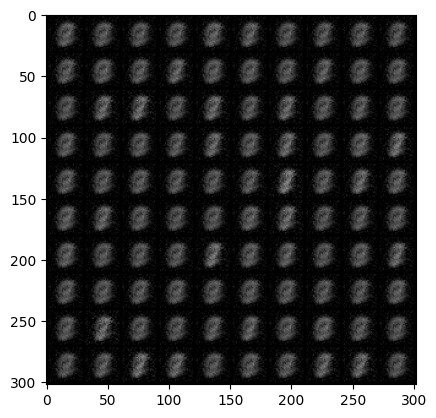

epoch:1, discriminator's loss:0.8436418979533954, generator's loss:4.0483789240627654
epoch:2, discriminator's loss:0.6344380586513324, generator's loss:3.621884879781239
epoch:3, discriminator's loss:0.4978184097055306, generator's loss:3.6015364359945123
epoch:4, discriminator's loss:0.3912055027911436, generator's loss:4.1536612248878235


epoch:5, discriminator's loss:0.24716123944120622, generator's loss:4.728665197581879


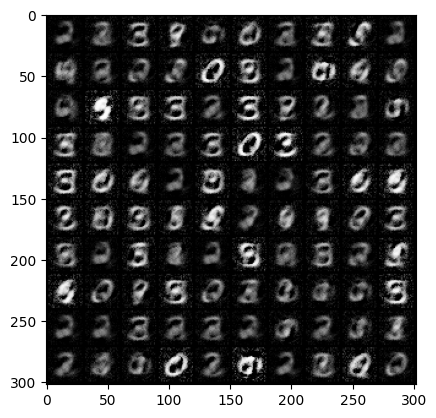

epoch:6, discriminator's loss:0.1745912226886034, generator's loss:5.400152505842099
epoch:7, discriminator's loss:0.12291346943037691, generator's loss:6.307896460297266
epoch:8, discriminator's loss:0.11265149223469277, generator's loss:6.490788974741629
epoch:9, discriminator's loss:0.09905824496168524, generator's loss:6.570172147710186


epoch:10, discriminator's loss:0.07977021877755171, generator's loss:7.064970907626122


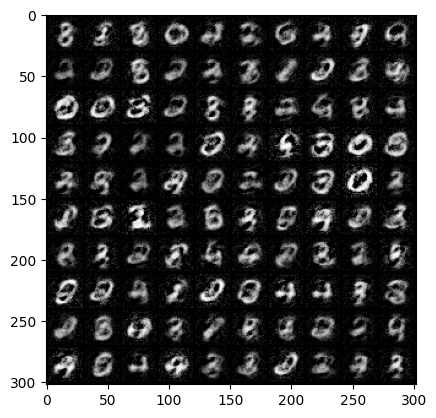

epoch:11, discriminator's loss:0.06746851295646804, generator's loss:7.285491173709634
epoch:12, discriminator's loss:0.06785419322490724, generator's loss:7.073344135081082
epoch:13, discriminator's loss:0.06915667277427195, generator's loss:7.167112967607055
epoch:14, discriminator's loss:0.06389149783059025, generator's loss:7.438208527656506


epoch:15, discriminator's loss:0.06657910014977798, generator's loss:7.631660892510974


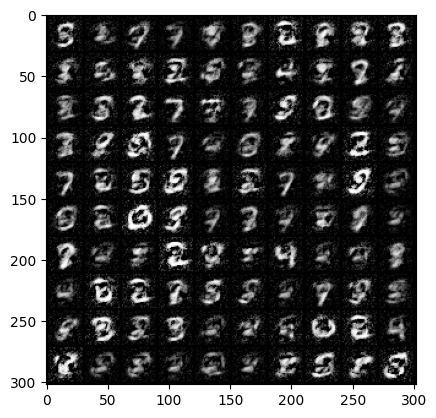

epoch:16, discriminator's loss:0.06743616738028006, generator's loss:7.305336623303671
epoch:17, discriminator's loss:0.06355397191905439, generator's loss:7.403458948074373
epoch:18, discriminator's loss:0.05878141018408619, generator's loss:8.049679550280704
epoch:19, discriminator's loss:0.0568064306528796, generator's loss:7.949345523614619


In [ ]:
g_net = Generator().to(device)
d_net = Discriminator().to(device)
train_gan(dataloader=mnist_train_dataloader, d_net=d_net, g_net=g_net)

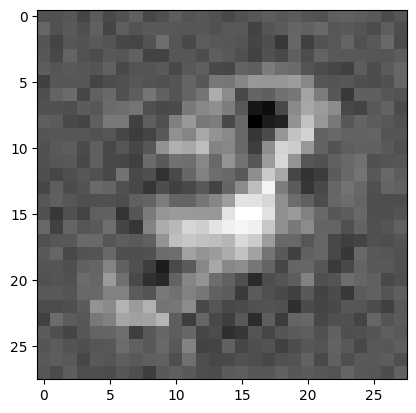

In [ ]:
fake = g_net(1)
images = fake.detach().to("cpu").view(-1, 1, 28, 28)
plt.imshow(images.squeeze(), cmap='gray')
plt.show()

# Transfer Learning

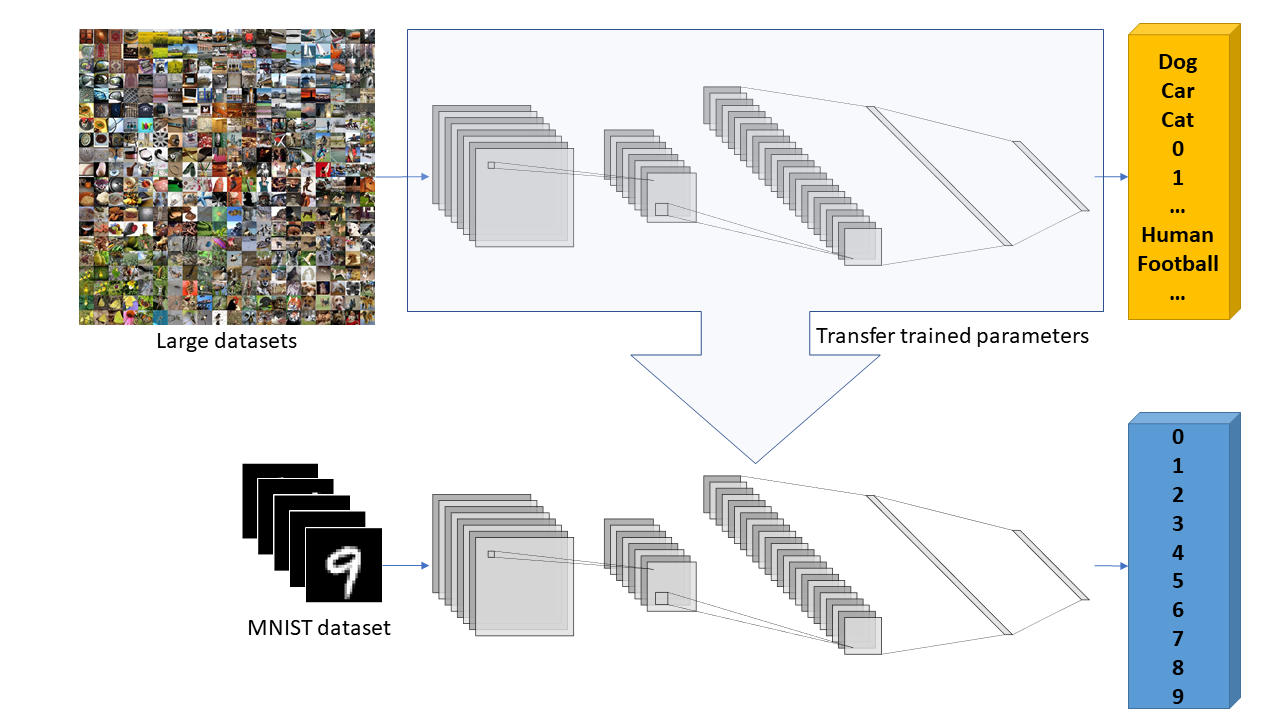

https://pytorch.org/vision/main/models.html

In [ ]:
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 175MB/s]


In [ ]:
weights.get_state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
                        [-1.1092e-01, -6.1004e-01, -3.3345e-01],
                        [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],
              
                       [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
                        [-1.3646e-01, -1.5367e+00, -1.5937e+00],
                        [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],
              
                       [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
                        [-1.1966e-01, -2.8122e-01, -2.1883e-01],
                        [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],
              
              
                      [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
                        [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
                        [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],
              
                       [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
                        [ 1.6213e+00, 

In [ ]:
print(model.named_modules)

<bound method Module.named_modules of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
      

In [ ]:
summary(model.to(device), input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

The typical process of transfer learning involves freezing some base layers of a pre-trained model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
cifar10_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have 10 classes (`'airplane'`,`'automobile'`,`'bird'`,`'cat'`,`'deer'`,`'dog'`,`'frog'`,`'horse'`,`'ship'`,`'truck'`).

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=10),
)

print(model.named_modules)

<bound method Module.named_modules of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
      

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

#Workshop

Create a custom GAN for Flower102 dataset using
1. A custom generator for 224*224 color images.
2. Transfer learning-based discriminator using `mobilenet_v3_small` parameters.
3. Create a training function for a given model.
4. Show a image result obtained from your generator.

## Conv2d-based generator.

In [ ]:
class Generator(nn.Module):
    def __init__(self,**kwargs):
        super(Generator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [512, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    def forward(self, batch_size):
        # z = torch.randn(1, 1024, 7, 7).to(device)
        z = torch.randn(batch_size, 1024, 7, 7).to(device)
        return self.net(z)

# summary(Generator(), input_size=(1,))

## Transfer learning-based discriminator using [mobilenet_v3_small](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.MobileNet_V3_Small_Weights) parameters.



In [ ]:
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = models.mobilenet_v3_small(weights=weights)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 46.3MB/s]


In [ ]:
print(model.named_modules)

<bound method Module.named_modules of MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=1),
    nn.Sigmoid()
)

# print(model.named_modules)

In [ ]:
summary(model.to(device), input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

## Create a training function for a given model.



epoch:0, discriminator's loss:1.3513186573982239, generator's loss:0.6813456565141678


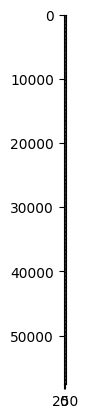

In [ ]:
# epoch 1
g_net = Generator().to(device)
d_net = model.to(device)
train_gan(dataloader=flowers102_train_dataloader, d_net=d_net, g_net=g_net, epochs=1)

## Show a image result obtained from your generator.





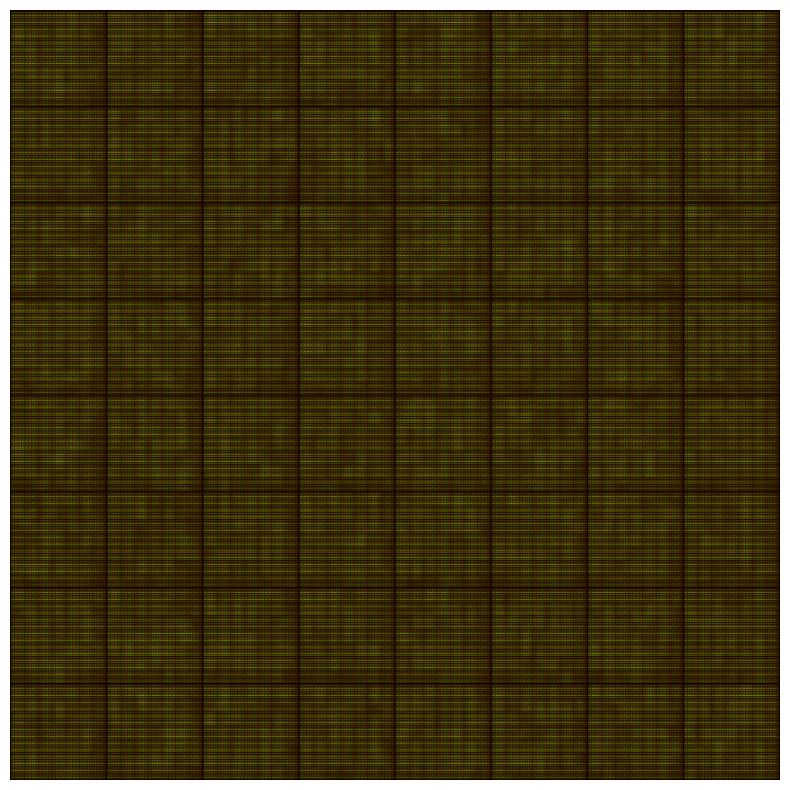

In [ ]:
fake_images = g_net(64)
fake_images = fake_images.cpu().detach()
grid = make_grid(fake_images, nrow=8)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()